In [41]:
import numpy as np
from scipy import linalg as lin
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

# Part 1

In [177]:
M = 101
zmin = 0.
zmax = 1e1
Dz = (zmax - zmin) / (M - 1e0)
z = zmin + Dz*np.arange(M)
mtrue = np.zeros(M)
mtrue[4] = 1.
mtrue[9] = 1.
mtrue[19] = 1.
mtrue[49] = 1.
mtrue[89] = 1.

In [178]:
N = 80
cmin = 0.
cmax = 1e-1
Dc = (cmax - cmin)
c = cmin + Dc*np.arange(N)
G = c[:, np.newaxis] * np.exp( - c[:, np.newaxis]*z)

sd = 1e-3
dtrue = np.dot(G, mtrue)
dobs = dtrue + np.random.normal( 0., sd , N )   # Noise: normal distribution with zero mean and 0.001 standard deviation

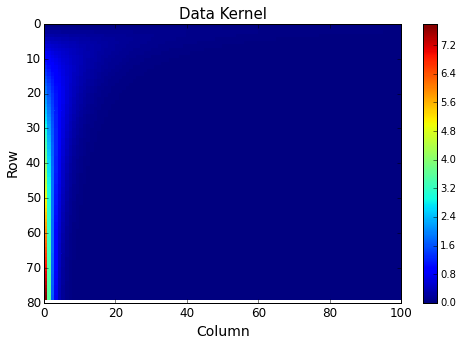

In [179]:
x = np.arange(101)
y = np.arange(80)

fig = plt.figure(figsize=(8,5))

ax = plt.gca()
ca = ax.pcolormesh(x, y, G)
cbar = fig.colorbar(ca)
ax.set_title(r'Data Kernel', fontsize=15)
ax.set_xlabel(r'Column', fontsize=14)
ax.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

In [197]:
print (G*Dz).sum(axis=1)

[ 0.          0.63896522  0.87604689  0.966031    1.00218156  1.01863742
  1.02789485  1.03452796  1.04021105  1.04555697  1.05079003  1.05599233
  1.06119393  1.06640582  1.07163203  1.07687401  1.08213232  1.08740714
  1.09269853  1.09800652  1.10333111  1.1086723   1.11403008  1.11940445
  1.1247954   1.13020292  1.135627    1.14106763  1.14652481  1.15199853
  1.15748877  1.16299554  1.16851881  1.17405857  1.17961482  1.18518755
  1.19077674  1.19638239  1.20200447  1.20764298  1.21329791  1.21896924
  1.22465696  1.23036106  1.23608152  1.24181832  1.24757146  1.25334091
  1.25912667  1.26492872  1.27074704  1.27658162  1.28243243  1.28829947
  1.29418272  1.30008215  1.30599776  1.31192951  1.31787741  1.32384142
  1.32982153  1.33581772  1.34182997  1.34785826  1.35390257  1.35996288
  1.36603917  1.37213141  1.3782396   1.38436371  1.3905037   1.39665958
  1.4028313   1.40901885  1.41522221  1.42144135  1.42767625  1.43392689
  1.44019324  1.44647528]


# Part 2

In [181]:
U, L, V = lin.svd(G)

print U.shape, L.shape, V.shape

(80, 80) (80,) (101, 101)


(array([  0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 6 Text yticklabel objects>)

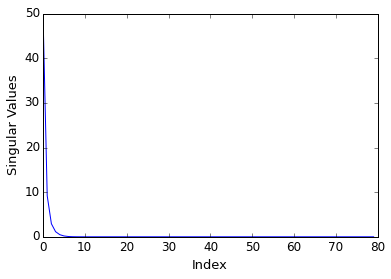

In [182]:
fig = plt.figure(figsize=(6,4))

ax = plt.gca()
ax.plot(L)
ax.set_xlabel(r'Index', fontsize=13)
ax.set_ylabel(r'Singular Values', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

From the figure above, we shall choose $p$ as $7$. The natural solution is derived as

$$\boldsymbol{m}^{est} = \boldsymbol{V}_P \boldsymbol{\Lambda}_P^{-1} \boldsymbol{U}_P^T \boldsymbol{d}^{obs}$$

In [183]:
p = 7
Up = U[:, :p].copy()
Vp = V[:, :p].copy()
Lp = L[:p].copy()
Lambdap1 = 1./Lp * np.identity(p)

In [184]:
mest_Nat = np.dot(np.dot( np.dot( Vp, Lambdap1 ), Up.T), dobs )

The model-parameter estimates for damped least square is

$$\boldsymbol{m}^{est} = \big[ \boldsymbol{G}^T \boldsymbol{G} + \epsilon^2 \boldsymbol{I} \big]^{-1} \boldsymbol{G}^T \boldsymbol{d}^{obs} $$

In [185]:
eps = 1e-3
mest_DLS = np.dot( np.dot( lin.inv( np.dot(G.T, G) + eps**2*np.identity(M) ), G.T ), dobs )

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 <a list of 10 Text yticklabel objects>)

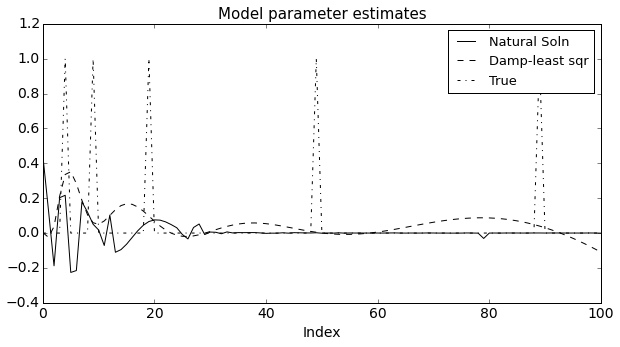

In [186]:
fig = plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(mest_Nat, 'k', label=r'Natural Soln')
ax.plot(mest_DLS, 'k--', label=r'Damp-least sqr')
ax.plot(mtrue, 'k-.', label=r'True')
ax.set_title(r'Model parameter estimates', fontsize=15)
ax.set_xlabel(r'Index', fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Comments

The natural solution has more negative values compared to the damped least square solution, which is an undesirable feature since the true model parameters are all non-negative. Except for the first peak in the true model parameters which the natural solution predicts correctly, neither of the estimated model parameters get the location of the true peaks exactly. It is interesting the natural solution is almost flat below the depth of 30. We could try to incorporate the effects of the peaks in the deeper depths by increasing $p$ but this would also increase more sidelobes.

The model resolution matrix and covariance matrix are

$$ \boldsymbol{R} = \boldsymbol{G}^{-g} \boldsymbol{G} = \boldsymbol{V}_P \boldsymbol{V}_P^T $$

$$ cov_u( \boldsymbol{m}^{est} ) = {\sigma_d}^2 \boldsymbol{G}^{-g} cov( \boldsymbol{d}^{obs} ) {\boldsymbol{G}^{-g}}^T = \boldsymbol{G}^{-g} {\boldsymbol{G}^{-g}}^T $$

where $\boldsymbol{G}^{-g} = \boldsymbol{V}_P \boldsymbol{\Lambda}_P^{-1} \boldsymbol{U}_P^T $.

In [187]:
print Up.shape, Vp.shape, Lp.shape

(80, 7) (101, 7) (7,)


In [188]:
R = np.dot(Vp, Vp.T)
Gg = np.dot( np.dot( Vp, Lambdap1 ), Up.T )
cov_m = np.dot( Gg, Gg.T )

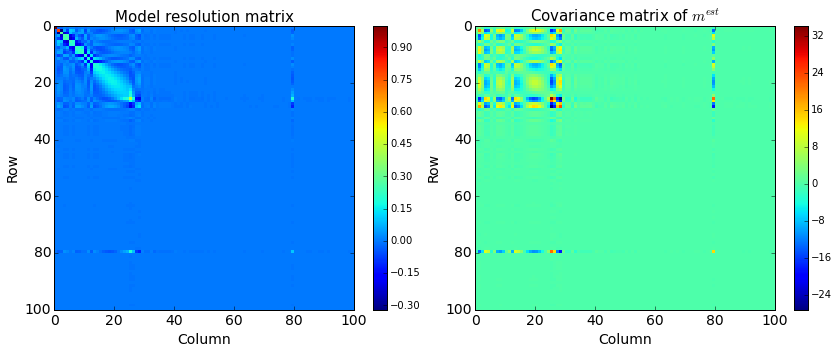

In [189]:
x = np.arange(101)
y = x.copy()

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ca1 = ax1.pcolormesh(x, y, R)
cbar = fig.colorbar(ca1)
ax1.set_title(r'Model resolution matrix', fontsize=15)
ax1.set_xlabel(r'Column', fontsize=14)
ax1.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax2 = fig.add_subplot(122)
ca2 = ax2.pcolormesh(x, y, cov_m)
cbar = fig.colorbar(ca2)
ax2.set_title(r'Covariance matrix of $m^{est}$', fontsize=15)
ax2.set_xlabel(r'Column', fontsize=14)
ax2.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

The spread and size of matrix $\boldsymbol{R}$ and vector $\boldsymbol{m}$ is defined as

$$ spread(\boldsymbol{R}) = || \boldsymbol{R} - \boldsymbol{I} ||^2_2, \ \ \ \ size( cov_u( \boldsymbol{m}) ) = \big| \big| var_u( \boldsymbol{m} )^{1/2} \big| \big|_2^2 $$

In [190]:
spR = ( (R - np.identity(M))**2 ).sum()
szm = ( np.diagonal(cov_m) ).sum()

print spR, szm

94.0 236.074027346


## Comments

The spread of the model resolution matrix is $94.0$ and the size of the covariance matrix of the estimated model parameters is $236.1$

In [191]:
for p in range(N, -1, -1):

    Up = U[:, :p].copy()
    Vp = V[:, :p].copy()
    Lp = L[:p].copy()
    Lambdap1 = 1./Lp * np.identity(p)
    
    mest_Nat = np.dot(np.dot( np.dot( Vp, Lambdap1 ), Up.T), dobs )
    
    R = np.dot(Vp, Vp.T)
    Gg = np.dot( np.dot( Vp, Lambdap1 ), Up.T )
    cov_m = np.dot( Gg, Gg.T )
    
    spR = ( (R - np.identity(M))**2 ).sum()
    szm = ( np.diagonal(cov_m) ).sum()
    
    
    if all( i < 1 for i in np.diagonal(cov_m) ):
        print p
        break

5


(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 <a list of 10 Text yticklabel objects>)

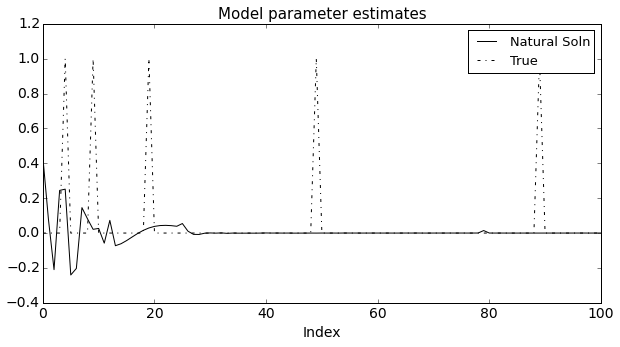

In [192]:
fig = plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(mest_Nat, 'k', label=r'Natural Soln')
ax.plot(mtrue, 'k-.', label=r'True')
ax.set_title(r'Model parameter estimates', fontsize=15)
ax.set_xlabel(r'Index', fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

As $p$ grows larger, the noise increases as well due to smaller scale fluctuations in the estimated model parameters. Thus, we shall choose the largest $p$ which satisfies the condition of the diagonal elements of unit covariance matrix being less than unity for all depths.

In [193]:
spR = ( (R - np.identity(M))**2 ).sum()
szm = ( np.diagonal(cov_m) ).sum()

print spR, szm

96.0 5.23495082433
